In [1]:
import os

import PIL
from PIL import Image
from PIL.ImageDraw import Draw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from scipy.ndimage import affine_transform
from keras import backend as K

import pandas as pd
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
MODEL_BASE = '../bounding/'
DATA = '../dados/'
TRAIN = os.path.join(DATA, 'train')
TEST = os.path.join(DATA, 'test')

In [3]:
model = load_model(os.path.join(MODEL_BASE, 'cropping_my.model'))

In [4]:
train_paths = [img for img in os.listdir(TRAIN)]
test_paths = [img for img in os.listdir(TEST)]

In [5]:
from PIL import Image as pil_image

# Define useful constants
img_shape  = (128,128,1)
anisotropy = 2.15

def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

def read_raw_image(p):
    return pil_image.open(p)

def read_for_validation(x):
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x, t

def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

def make_bbox(p):
    raw = read_array(p)
    width, height = raw.shape[1], raw.shape[0]
    img,trans         = read_for_validation(raw)
    a                 = np.expand_dims(img, axis=0)
    x0, y0, x1, y1    = model.predict(a).squeeze()
    (u0, v0),(u1, v1) = coord_transform([(x0,y0),(x1,y1)], trans)
    bbox = [max(u0,0), max(v0,0), min(u1,width), min(v1,height)]
    if bbox[0] >= bbox[2] or bbox[1] >= bbox[3]:
        bbox = [0,0,width,height]
    return bbox

In [6]:
bbox_df = pd.DataFrame(columns=['Image','x0','y0','x1','y1']).set_index('Image')

In [7]:
for img in tqdm(train_paths):
    bbox_df.loc[img] = make_bbox(os.path.join(TRAIN,img))
    
for img in tqdm(test_paths):
    bbox_df.loc[img] = make_bbox(os.path.join(TEST,img))

100%|██████████████████████████████████████████████████████████████████████████████| 7960/7960 [10:18<00:00, 12.87it/s]


In [8]:
bbox_df.to_csv("bounding_boxes.csv")


In [11]:
from keras.preprocessing import image

In [17]:
bbox_df.loc["00b92e9bf.jpg"]

x0     28.0
y0     69.0
x1    681.0
y1    305.0
Name: 00b92e9bf.jpg, dtype: float64

In [33]:
values = bbox_df.loc["0c81a988e.jpg"]

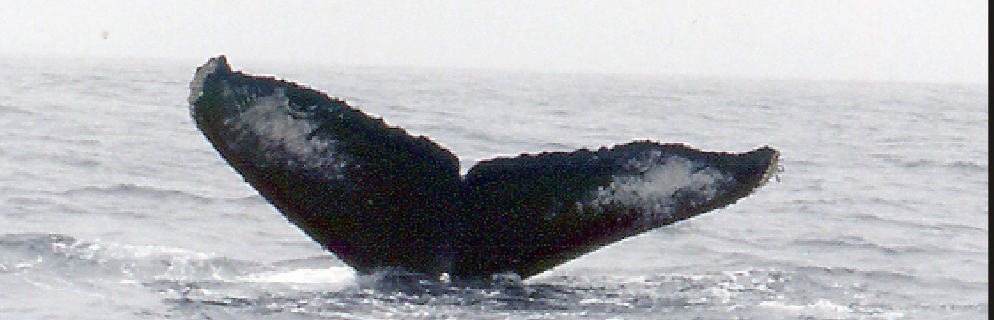

In [34]:
main_img = image.load_img("../dados/train/0c81a988e.jpg")
main_img.crop(tuple(np.array([values.x0,values.y0,values.x1,values.y1])))